In [1]:
import pandas as pd
import json
import os
import numpy as np
import time
import ipywidgets as widgets
from bqplot import *
import qgrid

pd.options.display.max_columns = 999


import matplotlib.pyplot as plt
from matplotlib.patches import Arc

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager
import seaborn as sns
from matplotlib import rcParams
import math
from PIL import Image

from highlight_text import ax_text
from matplotlib import animation
hfont = {'fontname':'Georgia'}

from scipy import optimize as op
from scipy.spatial import ConvexHull


from itertools import chain
import seaborn as sn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools


C:\Users\mishr\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\mishr\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load as lists

with open('all_games_filtered.json', 'r') as json_file:
    all_games = json.load(json_file)

In [3]:
def euclidean_distance(point1, point2):

    """
    euclidean_distance(point1, point2)
    
    Finds the euclidean distance between 2 given points with x,y coordinates

    Parameters
    -----------
    
    point1/point2 (np array): x, y coordinates
     
    Returns
    -----------
    
    distance (float): euclidean distance between the 2 given points

    """  

    return np.linalg.norm(point1 - point2)

def euclidean_similarity(array1, array2):

    """
    euclidean_distance(point1, point2)
    
    Finds the closest points between the points in two different sets, using the linear sum assignment problem.
    for more info. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

    Parameters
    -----------
    
    array1/array1 (np array):
     
    Returns
    -----------
    
    sum_dist (float): the total cost of the assignment 
    sol_rows (list): An array of row indices indices giving the optimal assignment. 
    sol_cols (list): An array of corresponding column indices giving the optimal assignment

    """  

    num_points1 = array1.shape[0]
    num_points2 = array2.shape[0]
    
    cost_matrix = np.zeros((num_points1, num_points2))
    
    for i in range(num_points1):
        for j in range(num_points2):
            cost_matrix[i, j] = euclidean_distance(array1[i], array2[j])
    

    # Perform linear sum assignment and get mean squared distance
    sol_rows, sol_cols = op.linear_sum_assignment(cost_matrix)
    sum_dist = cost_matrix[sol_rows, sol_cols].sum()
    # updated_cost_matrix = cost_matrix[sol_rows, sol_cols]


    return sum_dist, sol_rows, sol_cols


def active_players(x_coor, y_coor, attack_bool):
    
    if not attack_bool:
        distances = np.sqrt((x_coor - 105)**2 + (y_coor - 34)**2)

        # Find the index of the coordinates with the least distance
        min_distance_index = np.argmin(distances)
        
        x_coor = np.delete(x_coor, min_distance_index)
        y_coor = np.delete(y_coor, min_distance_index)

    # Remove coordinates that do not meet the conditions
    condition = (x_coor > 88) & (y_coor > 14) & (y_coor < 54)
    x_coor = x_coor[condition]
    y_coor = y_coor[condition]
    
    potential_zonal_markers = np.sum(x_coor > 99)
    
    
    
    return x_coor, y_coor, potential_zonal_markers

In [226]:
all_games.keys()

dict_keys(['0.json', '1.json', '2.json', '3.json', '4.json', '5.json', '6.json', '7.json', '8.json', '10.json', '11.json', '12.json', '13.json', '14.json', '15.json', '16.json', '18.json', '19.json', '20.json', '21.json', '22.json', '23.json', '24.json', '25.json', '26.json', '27.json', '28.json', '29.json', '30.json', '31.json', '32.json', '33.json', '34.json', '35.json', '36.json', '37.json', '38.json', '39.json', '40.json', '41.json', '42.json', '43.json', '44.json', '45.json', '46.json', '47.json', '48.json', '49.json', '50.json', '51.json', '52.json', '53.json', '54.json', '55.json', '56.json', '58.json', '59.json', '60.json', '61.json', '62.json', '63.json', '64.json', '65.json', '66.json', '67.json', '68.json', '69.json', '70.json', '71.json', '72.json', '73.json', '74.json', '75.json', '76.json', '77.json', '78.json', '79.json', '80.json', '81.json', '82.json', '83.json', '84.json', '85.json', '86.json', '87.json', '88.json', '89.json', '90.json', '92.json', '93.json', '94.json

In [227]:
# file_name = '66.json'
# corner_num = '3'

for file_name in all_games.keys():
    
    for corner_num in all_games[file_name].keys():


        frame_for_lsp = 0

        pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
                    pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

        fig, ax = pitch.draw(figsize=(14, 12))
        fig.set_facecolor('#1b1f2b')


        # then setup the pitch plot markers we want to animate
        marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
        ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
        away, = ax.plot([], [], ms=10, markerfacecolor='#b94b75', **marker_kwargs)  # red/maroon
        home, = ax.plot([], [], ms=10, markerfacecolor='#7f63b8', **marker_kwargs)  # purple


        # animation function
        def animate(i):

        #     i = 70
            """ Function to animate the data. Each frame it sets the data for the players and the ball."""
            # set the ball data with the x and y positions for the ith frame
            ball.set_data(np.array(all_games[file_name][corner_num]['ball_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['ball_coors'][i])[:, 0])

            # get the frame id for the ith frame

            # set the player data using the frame id
            away.set_data(np.array(all_games[file_name][corner_num]['defending_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['defending_coors'][i])[:, 0])
            home.set_data(np.array(all_games[file_name][corner_num]['attacking_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['attacking_coors'][i])[:, 0])

            return ball, away, home

        # call the animator, animate so 25 frames per second
        anim = animation.FuncAnimation(fig, animate, frames=len(all_games[file_name][corner_num]['ball_coors']), interval=200, blit=True)
        # writergif = animation.PillowWriter(fps=30)
        #nim.save('79json_3_straight.gif',writer=writergif) a

        # pitch.scatter(88, 14, marker = 'x',ax=ax,zorder=3,s=100, color = "yellow")

        # pitch.scatter(99, 35, marker = 'x',ax=ax,zorder=3,s=100, color = "yellow")


        # defence_coord = np.column_stack(active_players(np.array(all_games[file_name][corner_num]['defending_coors'])[frame_for_lsp][:, 0], np.array(all_games[file_name][corner_num]['defending_coors'])[frame_for_lsp][:, 1], False)[:2])
        # attack_coord = np.column_stack(active_players(np.array(all_games[file_name][corner_num]['attacking_coors'])[frame_for_lsp][:, 0], np.array(all_games[file_name][corner_num]['attacking_coors'])[frame_for_lsp][:, 1], True)[:2])

        # cost, sol_rows, sol_cols = euclidean_similarity(attack_coord, defence_coord)


        # for rows in range(len(sol_rows)):
        #     pitch.plot((attack_coord[sol_rows[rows]][0],defence_coord[sol_cols][rows][0]),(attack_coord[sol_rows[rows]][1],defence_coord[sol_cols][rows][1]),color='yellow', linewidth=2, ax=ax)


#         ax.text(s = "Prediction based on Cost - " + all_games[file_name][corner_num]['d_type'], y = 40, x = 67, color = 'white', size = 20)
        
        cost, _, _, _, _,_,_, gmm_all, gmm_single, kmeans = data_to_cluster[data_to_cluster['file_name_entry'] == (file_name + "_" + corner_num)].values[0]
                           
    
#         if int(data_to_cluster[data_to_cluster['file_name_entry'] == (file_name + "_" + corner_num)]['cluster'].iloc[0]) == 0:
#                pred_gmm = "Man-Mark"
#         else:
#                pred_gmm = "Zone"
        
#         del all_games[file_name][corner_num]['d_type']
        
        
        ax.text(s = "Predictions -:", y = 45, x = 67, color = 'white', size = 20)
    
        ax.text(s = "GMM: Cost & 6 yard bodies - " + str(gmm_all), y = 40, x = 67, color = 'white', size = 20)
        
        all_games[file_name][corner_num]['defence_type_gmm_all'] = gmm_all
        

        ax.text(s = "GMM: Cost only- " + str(gmm_single), y = 35, x = 67, color = 'white', size = 20)
        
        all_games[file_name][corner_num]['gmm_single'] = gmm_single
        
        ax.text(s = "KMeans: Cost only- " + str(kmeans), y = 30, x = 67, color = 'white', size = 20)
        
        all_games[file_name][corner_num]['kmeans'] = kmeans

        ax.text(s = "Cost - " + str(cost), y = 25, x = 67, color = 'white', size = 20)
        
        all_games[file_name][corner_num]['cost'] = float(cost)
        
        plt.savefig("predicted_defensive_setups/" + str(file_name.split('.')[0] + "_" + corner_num),dpi=480,bbox_inches='tight',facecolor='#1b1f2b')
#         plt.show()
        plt.close()



In [240]:
file_name = '86.json'
corner_num = '0'

swap = all_games[file_name][corner_num]['attacking_coors']
all_games[file_name][corner_num]['attacking_coors'] = all_games[file_name][corner_num]['defending_coors']

all_games[file_name][corner_num]['defending_coors'] = swap

Visualize Corner Frame

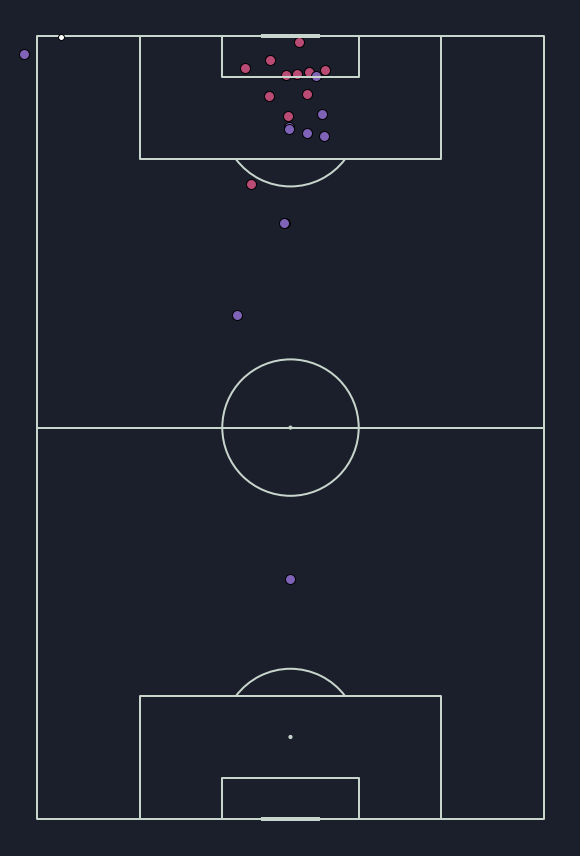

In [254]:
#visualize

file_name = '76.json'
corner_num = '10'

pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')


# then setup the pitch plot markers we want to animate
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away, = ax.plot([], [], ms=10, markerfacecolor='#b94b75', **marker_kwargs)  # red/maroon
home, = ax.plot([], [], ms=10, markerfacecolor='#7f63b8', **marker_kwargs)  # purple


# animation function
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    # set the ball data with the x and y positions for the ith frame
    ball.set_data(np.array(all_games[file_name][corner_num]['ball_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['ball_coors'][i])[:, 0])
    
    # get the frame id for the ith frame

    # set the player data using the frame id
    away.set_data(np.array(all_games[file_name][corner_num]['defending_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['defending_coors'][i])[:, 0])
    home.set_data(np.array(all_games[file_name][corner_num]['attacking_coors'][i])[:, 1], np.array(all_games[file_name][corner_num]['attacking_coors'][i])[:, 0])
    
    return ball, away, home


# call the animator, animate so 25 frames per second
anim = animation.FuncAnimation(fig, animate, frames=len(all_games[file_name][corner_num]['ball_coors']), interval=200, blit=True)
# writergif = animation.PillowWriter(fps=30)
# anim.save('filename_66_3.gif',writer=writergif)

plt.show()





In [149]:
frame_for_lsp = 0
cost_list = []
zone_markers = []
attackers_in_six_yard = []
file_name_entry = []

for file_name in all_games.keys():
    
    for corner_num in all_games[file_name].keys():
        
        
        x_def, y_def, potential_zone_defenders = active_players(np.array(all_games[file_name][corner_num]['defending_coors'][0])[:, 0], np.array(all_games[file_name][corner_num]['defending_coors'][0])[:, 1], False)
        defence_coord = np.column_stack((x_def,y_def))
        
        x_att, y_att, num_attackers_in_six_yard = active_players(np.array(all_games[file_name][corner_num]['attacking_coors'][0])[:, 0], np.array(all_games[file_name][corner_num]['attacking_coors'][0])[:, 1], True)
        attack_coord = np.column_stack((x_att, y_att))

        cost, sol_rows, sol_cols = euclidean_similarity(attack_coord, defence_coord)
        
        cost_list.append(round(cost, 3))
        
        #to find non  matched defenders - zonal markers - find ones inside the 6 yard box
        

        all_games[file_name][corner_num]['potential_zone_markers'] = potential_zone_defenders
        all_games[file_name][corner_num]['attackers_in_six_yard'] = num_attackers_in_six_yard
        

        zone_markers.append(potential_zone_defenders)
        attackers_in_six_yard.append(num_attackers_in_six_yard)
        file_name_entry.append(file_name + "_" + corner_num)
            

In [150]:
data_to_cluster = pd.DataFrame(np.transpose(np.array((cost_list,zone_markers,attackers_in_six_yard, file_name_entry)))
, columns=['cost', 'zone_markers', 'attackers_in_six_yard', 'file_name_entry'])

data_to_cluster

,cost,zone_markers,attackers_in_six_yard,file_name_entry
0,6.37,3,1,0.json_0
1,7.343,3,2,0.json_1
2,13.322,4,2,0.json_2
3,8.063,2,0,0.json_3
4,7.703,2,0,0.json_4
...,...,...,...,...
623,6.743,1,0,99.json_2
624,15.985,2,0,99.json_3
625,6.266,1,0,99.json_4
626,8.489,1,0,99.json_5


In [154]:
gm = GaussianMixture(n_components=2, random_state=0).fit(data_to_cluster[['cost', 'zone_markers', 'attackers_in_six_yard']].values)


In [155]:
gm.means_

array([[ 7.95534413,  2.72479859,  0.75428035],
       [21.84636518,  4.57006911,  0.67450997]])

In [162]:
gm.predict_proba([[ 5.05514469,  2.73069868, 1.70663914]])

array([[0.9142916, 0.0857084]])

In [163]:
labels = gm.predict(data_to_cluster[['cost', 'zone_markers', 'attackers_in_six_yard']].values)

In [164]:
data_to_cluster['cluster'] = labels

In [165]:
np.sum(labels == 0)

357

In [166]:
np.sum(labels == 1)

271

In [167]:
gm_single_feature = GaussianMixture(n_components=2, random_state=0).fit(data_to_cluster[['cost']].values)


In [168]:
gm_single_feature.means_

array([[ 8.02603679],
       [22.51751421]])

In [170]:
labels_single_feature = gm_single_feature.predict(data_to_cluster[['cost']].values)

In [171]:
data_to_cluster['cluster_single_feature'] = labels_single_feature

In [172]:
np.sum(labels_single_feature == 0)

378

In [173]:
np.sum(labels_single_feature == 1)

250

In [174]:
n_clusters = 2

# Fit K-Means model
kmeans_single_feature = KMeans(n_clusters=n_clusters, random_state=42).fit(data_to_cluster[['cost']].values)


In [175]:
kmeans_labels = kmeans_single_feature.labels_

In [179]:
np.sum(kmeans_labels == 0)

192

In [180]:
np.sum(kmeans_labels == 1)

436

In [ ]:
#add predictions & cost to all_games

In [188]:
data_to_cluster['kmeans_single_feature'] = kmeans_labels

In [211]:
data_to_cluster['gmm_all'] = np.where(data_to_cluster['cluster'] == 0, 'Man-Mark', 'Zone')


In [213]:
data_to_cluster['gmm_single'] = np.where(data_to_cluster['cluster_single_feature'] == 0, 'Man-Mark', 'Zone')


In [214]:
data_to_cluster['kmeans_single'] = np.where(data_to_cluster['kmeans_single_feature'] == 0, 'Man-Mark', 'Zone')


In [216]:
data_to_cluster.head()

,cost,zone_markers,attackers_in_six_yard,file_name_entry,cluster,cluster_single_feature,kmeans_single_feature,gmm_all,gmm_single,kmeans_single
0,6.37,3,1,0.json_0,0,0,0,Man-Mark,Man-Mark,Man-Mark
1,7.343,3,2,0.json_1,0,0,0,Man-Mark,Man-Mark,Man-Mark
2,13.322,4,2,0.json_2,0,1,0,Man-Mark,Zone,Man-Mark
3,8.063,2,0,0.json_3,0,0,0,Man-Mark,Man-Mark,Man-Mark
4,7.703,2,0,0.json_4,0,0,0,Man-Mark,Man-Mark,Man-Mark
